In [1]:
from nltk import word_tokenize, download
download("punkt_tab")
download("stopwords")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reetibandyopadhyay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reetibandyopadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from nltk import word_tokenize, download # Ensure nltk is imported

# It's good practice to call nltk.download() at a more global scope or ensure it's run once.
# These lines are already in your file, ensure 'punkt' is available for word_tokenize.
download("punkt_tab") 
download("stopwords") # Not used in this specific change but kept from original

#df = pd.read_csv('../stage_4_data/text_generation/data.csv') # I changed it to data.csv
df = pd.read_csv('../stage_4_data/data.csv') # just for my directory structure
df.head()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reetibandyopadhyay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reetibandyopadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,Joke
0,1,What did the bartender say to the jumper cable...
1,2,Don't you hate jokes about German sausage? The...
2,3,Two artists had an art contest... It ended in ...
3,4,Why did the chicken cross the playground? To g...
4,5,What gun do you use to hunt a moose? A moosecut!


In [5]:
class TextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, rnn_type="RNN", dropout_prob=0.2):
        super(TextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_type = rnn_type.upper()
        
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        if self.rnn_type == "LSTM":
            out, (hn, cn) = self.rnn(x)
        else:
            out, hn = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


# Define special tokens
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>" # Token for unknown words

# Get jokes from DataFrame
raw_jokes = df['Joke'].astype(str).tolist()

# Create word vocabulary
all_words_for_vocab = []
for joke_str in raw_jokes:
    tokens = word_tokenize(joke_str.lower()) # Tokenize and convert to lowercase
    all_words_for_vocab.extend(tokens)

unique_words_from_data = sorted(list(set(all_words_for_vocab)))

# Add special tokens to the word list
words = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + unique_words_from_data # Changed from chars
word_to_int = {word: i for i, word in enumerate(words)} # Changed from char_to_int
int_to_word = {i: word for i, word in enumerate(words)} # Changed from int_to_char

vocab_size = len(words) # Changed from len(chars)
print(f"Word Vocabulary Size (including SOS/EOS/UNK): {vocab_size}")

embedding_dim = 128 # tunable old: 64
hidden_size = 256  # tunable: old 128
output_size = vocab_size # Output size must match new vocab_size
#learning_rate = 0.001
learning_rate = 0.0001 #trying shorter learning rate
#sequence_length = 25 # Length of input sequences (now in words)
sequence_length = 15 # trying a shorter sequence length
epochs = 200 # Number of epochs
dropout_probability = 0.5

# Prepare training data
dataX = []
dataY = []

for joke_str in raw_jokes:
    # Tokenize joke into words, add SOS/EOS, and convert to lowercase
    tokenized_joke_words = [SOS_TOKEN] + word_tokenize(joke_str.lower()) + [EOS_TOKEN]
    
    # Convert words to integers, using UNK_TOKEN for out-of-vocabulary words
    # (though all words from raw_jokes should be in vocab here as it's built from them)
    int_joke = [word_to_int.get(word, word_to_int[UNK_TOKEN]) for word in tokenized_joke_words]
    
    # Create sequences from this single joke
    # A sequence needs at least sequence_length + 1 tokens (words) to form one input-output pair
    if len(int_joke) > sequence_length:
        for i in range(0, len(int_joke) - sequence_length, 1):
            seq_in = int_joke[i : i + sequence_length]
            seq_out = int_joke[i + sequence_length] # The target word (or EOS_TOKEN)
            dataX.append(seq_in)
            dataY.append(seq_out)

n_patterns = len(dataX)
print("Total Patterns: ", n_patterns) # This will likely change

split_idx = int(n_patterns * 0.8)

# train_dataX = dataX[:split_idx]
# train_dataY = dataY[:split_idx]
# test_dataX = dataX[split_idx:]
# test_dataY = dataY[split_idx:]

# X_train = torch.tensor(train_dataX, dtype=torch.long)
# Y_train = torch.tensor(train_dataY, dtype=torch.long)
# X_test = torch.tensor(test_dataX, dtype=torch.long)
# Y_test = torch.tensor(test_dataY, dtype=torch.long)

# trying to use all data for training - getting rid of val and seeing what happens


X_train = torch.tensor(dataX, dtype=torch.long)
Y_train = torch.tensor(dataY, dtype=torch.long)


# Instantiate the model - this will now use the updated vocab_size
model = TextGenerator(vocab_size, embedding_dim, hidden_size, output_size,
                      rnn_type="LSTM", dropout_prob=dropout_probability)
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# val_data = torch.utils.data.TensorDataset(X_test, Y_test)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False) # commenting out val for now

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# The training loop would typically be in your main script (e.g., main.ipynb)
# or called from there if this helper.py is imported.
# For completeness, if you intend to run training directly from this script,
# you would add the training loop here:
#
train_losses = []
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # added gradient clipping
        optimizer.step()
        train_loss_epoch += loss.item()
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)  # Store loss for plotting
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}')

    # Validation phase - commenting out for now
    # model.eval()
    # val_loss = 0
    # with torch.no_grad():
    #     for batch_X_val, batch_y_val in val_loader:
    #         outputs_val = model(batch_X_val)
    #         loss_val = criterion(outputs_val, batch_y_val)
    #         val_loss += loss_val.item()
    
    # avg_val_loss = val_loss / len(val_loader)
    # print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

print("Training complete.")

Word Vocabulary Size (including SOS/EOS/UNK): 4731
Total Patterns:  8922
Epoch [1/200], Training Loss: 8.1813
Epoch [2/200], Training Loss: 5.7967
Epoch [3/200], Training Loss: 5.5679
Epoch [4/200], Training Loss: 5.4729
Epoch [5/200], Training Loss: 5.4043
Epoch [6/200], Training Loss: 5.3565
Epoch [7/200], Training Loss: 5.3088
Epoch [8/200], Training Loss: 5.2726
Epoch [9/200], Training Loss: 5.2157
Epoch [10/200], Training Loss: 5.1782
Epoch [11/200], Training Loss: 5.1343
Epoch [12/200], Training Loss: 5.1013
Epoch [13/200], Training Loss: 5.0554
Epoch [14/200], Training Loss: 5.0195
Epoch [15/200], Training Loss: 4.9826
Epoch [16/200], Training Loss: 4.9297
Epoch [17/200], Training Loss: 4.9027
Epoch [18/200], Training Loss: 4.8575
Epoch [19/200], Training Loss: 4.8157
Epoch [20/200], Training Loss: 4.7756
Epoch [21/200], Training Loss: 4.7309
Epoch [22/200], Training Loss: 4.7039
Epoch [23/200], Training Loss: 4.6573
Epoch [24/200], Training Loss: 4.6168
Epoch [25/200], Training

In [53]:
len(dataX), len(dataY)

(8922, 8922)

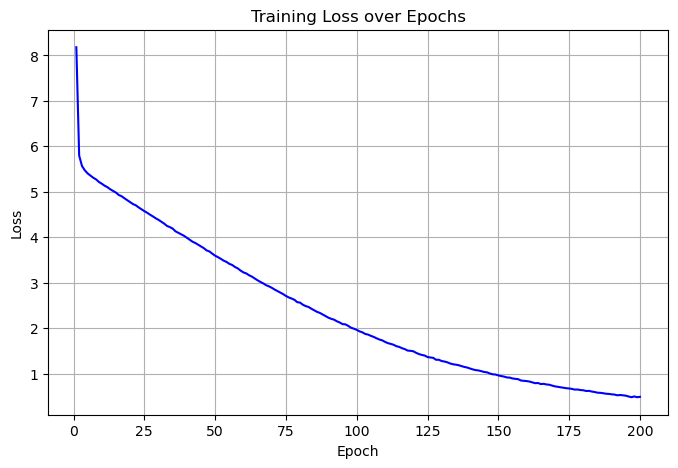

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [22]:

# Generate text
model.eval()  # Set model to evaluation mode

# Parameters for generation
start_string = "What did" # Or any other seed text
num_words_to_generate = 50 # Maximum number of words to generate
temperature = 0.8 # Higher temperature results in more random, lower in more predictable text

# Tokenize the start string and convert to integers
tokenized_start_string = word_tokenize(start_string.lower())
pattern = [word_to_int.get(word, word_to_int[UNK_TOKEN]) for word in tokenized_start_string]

if not pattern:
    print(f"Error: Seed string '{start_string}' contains no known words or is too short after tokenization.")
    # Fallback to a default known pattern if the seed is problematic
    # Using SOS_TOKEN as a starting point if the original start_string is empty or all unknown
    pattern = [word_to_int[SOS_TOKEN]] * min(sequence_length, 5) # Use a short sequence of SOS_TOKEN
    # Reconstruct start_string for printing purposes, though it might just be SOS tokens
    start_string_for_print = " ".join([int_to_word.get(p, UNK_TOKEN) for p in pattern])
    print(f"Using fallback seed: '{start_string_for_print}'")
else:
    start_string_for_print = " ".join([int_to_word.get(p, UNK_TOKEN) for p in pattern])


generated_words = [int_to_word.get(p, UNK_TOKEN) for p in pattern] # Store generated words

print(f"Seed: \"{start_string_for_print}\"")
print("Generated text: ")
print("--------------------------")
print(start_string_for_print, end=" ") # Print with a space at the end

with torch.no_grad():  # No need to track gradients
    for i in range(num_words_to_generate):
        # Ensure the pattern is of the correct sequence_length for input
        # If pattern is shorter than sequence_length, pad with UNK_TOKEN (or SOS_TOKEN)
        # For simplicity, we'll just take the last part if it's long enough,
        # or the whole pattern if it's shorter.
        # The model expects sequence_length inputs.
        
        current_sequence_input_indices = pattern[-sequence_length:]
        
        # Prepare input tensor
        input_tensor = torch.tensor([current_sequence_input_indices], dtype=torch.long)
        # input_tensor = input_tensor.to(device) # Uncomment if using GPU

        # Get model output (logits)
        output = model(input_tensor)
        
        # Apply temperature to logits
        output_dist = output.data.view(-1).div(temperature).exp()
        # Sample from the distribution
        predicted_word_index = torch.multinomial(output_dist, 1)[0].item()
        
        # Get the predicted word
        predicted_word = int_to_word.get(predicted_word_index, UNK_TOKEN)

        if predicted_word == EOS_TOKEN:
            print(f" {EOS_TOKEN}") # Print EOS token
            break # Stop generation if EOS token is predicted
        
        generated_words.append(predicted_word)
        pattern.append(predicted_word_index)
        print(predicted_word, end=" ", flush=True) # Print word with a space
        
        # Slide the window: ensure pattern doesn't grow indefinitely beyond what's needed for context
        if len(pattern) > sequence_length:
            pattern = pattern[1:]


print("\n--------------------------")
print("\nGeneration complete.")

# Full generated text:
print("Full generated joke: ", " ".join(generated_words))

Seed: "what did"
Generated text: 
--------------------------
what did software : //i.imgur.com/btyf5ys.jpg fingers cardboard ordering sure ? a little  <EOS>

--------------------------

Generation complete.
Full generated joke:  what did software : //i.imgur.com/btyf5ys.jpg fingers cardboard ordering sure ? a little
